# Stefan Problem - test melting and solidification

Step 1 - import packages

In [2]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions

using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Temperature.jl")
include("GridOperations.jl")
include("Topo.jl")
include("Entropy.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [3]:
function temp_of_P_S(Tref::Float64,Tm::Float64,X::Float64,Hfus::Float64,Cv::Float64,S::Float64)
    T = exp(S/Cv + log(Tref) - Hfus*X/Cv*Tm)
    return T
end

function entropy_of_P_T(Tref::Float64,Tm::Float64,X::Float64,Hfus::Float64,Cv::Float64,T::Float64)
    S = Cv*(log(T) - log(Tref)) + Hfus*X/Tm
    return S
end

entropy_of_P_T (generic function with 1 method)

Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [6]:
function get_lambda1()
    #L::Float64,Tm::Float64,To::Float64,c::Float64)
    Tm = 273.0
    To = 100.0
    L = 334.0*10^3 
    c = 2100.0
    dT = Tm - To
    f(lambda1) = L * sqrt(pi) / (c * (Tm - To)) - exp(-lambda1^2) / (lambda1 * erf(lambda1))
    g(lambda1) = f(lambda1)
    initial_guess = 1.0
    lambda1_solution = fzero(g,initial_guess)
    return lambda1_solution
end

function get_t(lambda1::Float64)
    ym = 1.0e4
    kappa = 1.0e-3 # 
    t = ym^2 / 4*lambda1*kappa
    return t
end

function get_eta(y::Float64,t::Float64)
    kappa = 1.0e-3 
    eta = y / 2*sqrt(kappa*t)
    return eta
end

function get_theta(eta::Float64,lambda1::Float64)
    theta = erf(eta) / erf(lambda1)
    return theta
end

function stefan_initial_condition(theta::Float64)
    Tm = 273.0
    To = 100.0
    T = theta*(Tm-To) + To
    return T
end

function initial_top(x::Float64)
    return 0.0
end 

function initial_bot(x::Float64)
    return 1.0e4
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,1000.0],[0.0,0.0,0.0],[4180.0,2100.0],[0.5610,2.1])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        end 
    end 
end 

function update_melt_fraction(T::Float64)
    Tm = 273.0
    if T > Tm 
        X = 1.0
    elseif T < Tm
        X = 0.0
    else
        X = rand()
    end
    return X
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    En = markers.scalarFields["En"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    Cv = 4.22e3 # J/(kg*K)
    Tref = 100.0
    Tm = 273.0
    Hfus = 3.34e5 # J/kg
    # Setting up Stefan conidtion
    lambda1 = get_lambda1()
    t = get_t(lambda1)
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_bot(mx)
        hsurf = initial_top(mx)
        eta = get_eta(my,t)
        theta = get_theta(eta,lambda1)
        Ti = stefan_initial_condition(theta)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            X = update_melt_fraction(273.0)
            markers.scalars[En,i] = entropy_of_P_T(Tref,Tm,X,Hfus,Cv,273.0)
        elseif my > hsurf
             # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = Ti
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
            X = update_melt_fraction(Ti)
            markers.scalars[En,i] = entropy_of_P_T(Tref,Tm,X,Hfus,Cv,Ti)
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

In [12]:
function run()
    W = 1e5
    H = 1e5
    ny = 151
    nx = Int64(ceil(W/H*ny))
    gx = 0.0
    gy = 0.113

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    materials = Materials()
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","Cp","Hr","kThermal","En"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers,materials)

    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

    ### Setting up agruments for termination criteria ###
    max_step::Int64=5
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing
    Hr = nothing
    Cp_c = nothing
    T = nothing
    dTmax = nothing
    dTemp = nothing
    Tnew = nothing
    Tlast = nothing
    kThermal = nothing
    En = nothing
    En_new = nothing
    mat = nothing

    itime = 1 
    terminate = false
    while !terminate
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        rho_c_new,Cp_c_new,alpha_new,Hr_new,kThermal_new,En_new = marker_to_stag(markers,grid,["rho","Cp","alpha","Hr","kThermal","En"],"center")
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
       
        # deal with any NaN values from interpolation:
        if itime > 1
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
            replace_nan!(En,En_new)
        end
        # Copy field data
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        Tlast = copy(Tlast_new)    
        En = copy(En_new)



        # Compute the advection timestep
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end


        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        
        # Checking Termination Criteria, time is in Myr, amplitude is in meters
        if time >= max_time || itime >= max_step 
            terminate = true
        end
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
    end
    return grid,i_mat,mat,markers
end
grid,i_mat,mat,markers = run();

Creating Markers...
  0.034600 seconds (19 allocations: 83.429 MiB, 41.41% gc time)
Initial condition...
  0.146204 seconds (2.43 M allocations: 38.929 MiB)
Finished Step 2 time=0.31746031746031744 kyr
Finished Step 3 time=0.6349206349206349 kyr
Finished Step 4 time=0.9523809523809524 kyr
Finished Step 5 time=1.2698412698412698 kyr
Finished Step 6 time=1.5873015873015872 kyr


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


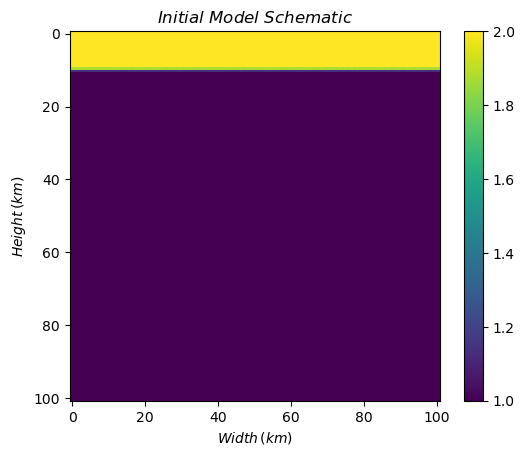

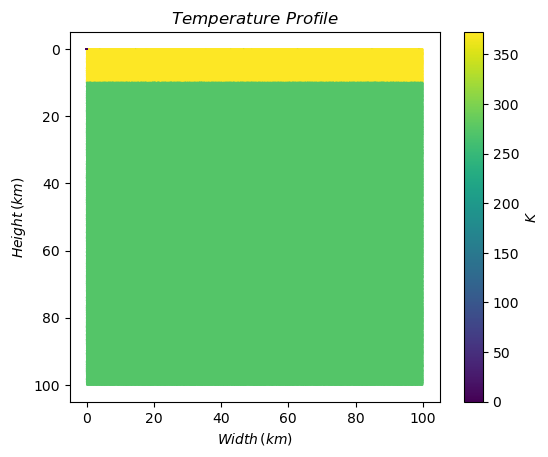

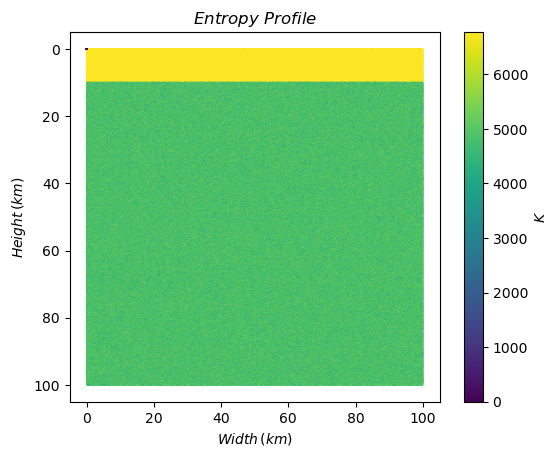

In [13]:
figure() 
pcolor(grid.xc/1000,grid.yc/1000,i_mat)
colorbar(cmap="viridis")
title(L"Initial\,\,Model\,\,Schematic")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
show()

figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
title(L"Temperature\,\,Profile")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
show()

figure()
scatter(markers.x[1,:]/1000,markers.x[2,:]/1000,c=markers.scalars[markers.scalarFields["En"],:],s=0.1)
title(L"Entropy\,\,Profile")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
show()